In [1]:
%load_ext autoreload
%autoreload 2
import yaml
import pandas as pd
# from pandas.core.common import SettingWithCopyWarning
pd.options.mode.chained_assignment = None
# import warnings
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
opj = os.path.join
opd = os.path.dirname
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from utils import *
from analyse import *

Z = norm.ppf

/data1/projects/dumoulinlab/Lab_members/Sumiya/programs/packages/AttnExps/TrialBased/analyse.py:109: OptimizeWarning: Covariance of the parameters could not be estimated
  except RuntimeError:
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Settings file:  /data1/projects/dumoulinlab/Lab_members/Sumiya/programs/packages/AttnExps/TrialBased/expsettings/expsettings_2afc.yml
1.0
2.0








ATTN: L                
Sigmoid mid-point: -6.730                
Yes/No Values [0.15, 0.85]: 7.730 , -6.730                
popt,pcov (array([-6.72951984, 13.33582895]), array([[inf, inf],
       [inf, inf]]))









ATTN: S                
Sigmoid mid-point: -6.730                
Yes/No Values [0.15, 0.85]: 7.730 , -6.730                
popt,pcov (array([-6.72951984, 13.33582895]), array([[inf, inf],
       [inf, inf]]))



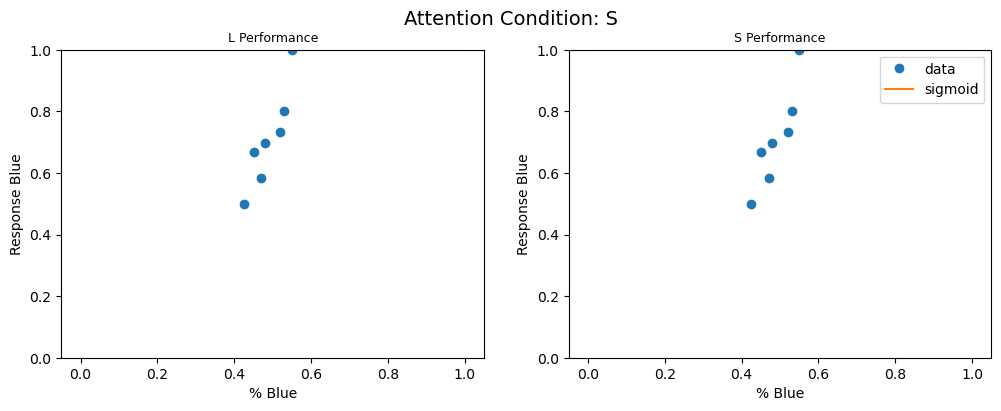

In [21]:
out='0_ses-0_task-2afcS_run-0' 
sub=out.split('_')[0]
tsk=out.split('_')[2].split('-')[-1][:-1]
attn=out.split('_')[2][-1].lower()
name='exp'

beh = AnalyseRun(out, tsk, attn,sub,name)
beh.analyse2afc()
# beh.analyseYesNo()

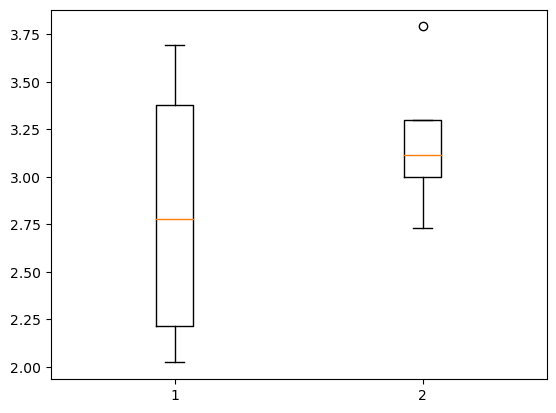

In [42]:
sub='sub-013'
n='exp'
substr=''#'ses-3_task-yesno'
if (substr == '') & (n == 'train'):
    substr='ses-0_task-yesno'
elif substr == '':
    substr='ses-1_task-yesno'
r=None
excl=['run-1','S_run-9']

pth=opj(os.getcwd(),'logs',sub)
fn=os.listdir(pth)#os.listdir(opj(os.environ['DIR_DATA_HOME'],f'sourcedata/{sub}/ses-1/prf/'))
fn=[f for f in fn if substr in f]
dL=[]
dS=[]

for f in fn:
    if any([ex in f for ex in excl]):
        continue 
    out=f[:-5]
    tsk=out.split('_')[2].split('-')[-1][:-1]
    attn=out.split('_')[2][-1].lower()
    name=n
    beh = AnalyseRun(out, tsk, attn,sub,name,verbose=False)
    beh.analyseYesNo(resp=r)
    if attn == 'l': 
        dL.append(beh.d)
    else:
        dS.append(beh.d)

plt.boxplot([dS,dL])
plt.show()


In [51]:
resp='b'
baseline=0.5
duration=1

runsdf=pd.DataFrame([])

for f in fn:
    df=None
    try:
        if any([ex in f for ex in excl]):
            continue 
    except TypeError:
        pass
    df=pd.read_table(opj(pth,f,f.rsplit('_',1)[0]+'_events.tsv'),keep_default_na=True)

    try:
        df['duration'] = df['duration'].fillna(0)
    except KeyError:
        df.loc[df.event_type == 'stim','duration'] = np.diff(df.loc[df.event_type == 'stim','onset'],append=np.nan)
    
    df = df.drop(df[(df.phase % 2 == 1) & (df.event_type == 'stim')].index.append(df[df.event_type == 'pulse'].index))
    df.drop(df[(df.duration > 1)].index,inplace=True)
    df.drop(df[pd.isna(df.duration) & (df.event_type != 'response')].index,inplace=True)

    df['sub']=f.split('_')[0]
    df['run']=f.split('_')[3].split('-')[-1]
    df['task']=f.split('_')[2].split('-')[-1][-1]
    df['nr_frames'] = df['nr_frames'].fillna(0)
    df['end'] = df.onset + df.duration
    df['end_abs'] = df.onset_abs + df.duration
    if resp not in df.response.unique():
        df.loc[df.response != 'nan','response'] = 'b'
    df['response'] = df.response.astype(str).apply(lambda x:x.lower())
    
    runsdf=pd.concat([runsdf,df],ignore_index=True)    

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [44]:
perm={}

perm['d']=[]
perm['c']=[]
perm['rt']=[]

for resprun in runsdf.run.unique():
    for respts in runsdf[(runsdf.run == resprun)].task.unique():
        resdf = runsdf[(runsdf.run == resprun) & (runsdf.task == respts)]
        if resp not in resdf.response.unique():
            resdf.loc[resdf.response != 'nan','response'] = resp
        responses = resdf.loc[resdf.response == resp]

        for run in runsdf.run.unique():
            for ts in runsdf[(runsdf.run == run)].task.unique():
                if (run == resprun) & (ts == respts):
                    continue
                df=runsdf[(runsdf.run == run)&(runsdf.task == ts)]
                stim_df = df[df.event_type == 'stim']
                cond = 'large_prop' if ts == 'L' else 'small_prop'
                sz=cond

                prop_values=[prop for prop in df[cond].unique() if not pd.isna(prop)]
                prop_values=[p for p in prop_values if p != 0.5]

                switch_loc = np.diff(stim_df[sz], prepend=baseline) != 0
                switch_loc = stim_df[(switch_loc) & (stim_df[sz] != baseline) & (stim_df[sz].notna())].index  # drop values where color_balance is 0.5

                tpos = sum([(abs(i - responses.onset) < duration).any() \
                        for i in stim_df.loc[switch_loc].end])  # true positives
                fneg = len(switch_loc) - tpos  # false negatives (missed switches)
                fpos = len(responses) - tpos  # false positives (responded with no switch)
                tneg = len(stim_df) - len(switch_loc) - fneg  # true negative

                d, c = d_prime(tpos, fneg, fpos, tneg)

                rts = [min(abs(responses.onset - i)) for i in df.loc[switch_loc].onset]
                rts = [r for r in rts if r < 2] 

                perm['d'].append(d)
                perm['c'].append(c)
                perm['rt'].append(np.asarray(rts).mean())

In [45]:
perm['d']

[0.7288856818510941,
 0.8296667669017174,
 0.8054639763562114,
 1.0210486340204654,
 0.8547501399085382,
 0.6011269531488876,
 0.3706914997145514,
 0.25862201646859706,
 0.5113330911202584,
 0.23944998708346898,
 0.39086433520908703,
 1.5059588897667646,
 0.3706914997145514,
 0.3706914997145514,
 0.7972676921187565,
 0.9084191417957656,
 0.3989707785317185,
 0.6801340568348365,
 0.5754987005311104,
 0.3989707785317185,
 0.9910981609950645,
 0.5004811524631869,
 0.3653658702590348,
 0.3653658702590348,
 1.1523233494424558,
 0.9777218621406125,
 0.48039189173876307,
 0.602922127467388,
 0.5741695752359839,
 0.2825449371149096,
 0.7001847109655094,
 1.1170616353237195,
 0.7218968540194187,
 0.7960614034266162,
 0.9070256814725361,
 0.7939825194137952,
 0.9957774714970152,
 0.5729708820557439,
 0.8725073953328687,
 1.1867231593598169,
 0.66449025969908,
 1.0658949736815457,
 0.24688761788139013,
 0.6607863894953955,
 0.3999166681194577,
 0.5160492109722825,
 0.3999166681194577,
 0.80001679

In [6]:
run='3'
ts='S'
resp='b'
baseline=0.5
duration=1

# for run in runsdf.run.unique():
#     for ts in runsdf[runsdf.run == run].task.unique():
#         df=runsdf[(runsdf.run == run) & (runsdf.task == ts)]

           
runsdf

NameError: name 'runsdf' is not defined

In [7]:
fname=opj(opd(os.environ['PATH_HOME']),'pRF_attention_task/Experiment/logs',sub,fn[0],fn[0].rsplit('_',1)[0]+'_events.tsv')
df=pd.read_table(fname,keep_default_na=True)
df.loc[df.event_type == 'stim','duration'] = np.diff(df.loc[df.event_type == 'stim','onset'],append=np.nan)

df = df.drop(df[(df.phase % 2 == 1) & (df.event_type == 'stim')].index.append(df[df.event_type == 'pulse'].index))
# df.drop(df[(df.duration > 1)].index,inplace=True)
# df.drop(df[pd.isna(df.duration) & (df.event_type != 'response')].index,inplace=True)
df['nr_frames'] = df['nr_frames'].fillna(0)
df['end'] = df.onset + df.duration
df['end_abs'] = df.onset_abs + df.duration
df['response'] = df.response.astype(str).apply(lambda x:x.lower())
stim_df = df[df.event_type == 'stim']
resp = 'b'
if resp not in df.response.unique():
    df.loc[df.response != 'nan','response'] = 'b'
df['response'] = df.response.astype(str).apply(lambda x:x.lower())
responses = df.loc[df.response == resp]

responses

,trial_nr,onset,event_type,phase,response,nr_frames,large_prop,small_prop,onset_abs,duration,end,end_abs
32,14,22.443210,response,3,b,0.0,0.5,0.675,75.439438,NaN,NaN,NaN
57,19,29.304346,response,2,b,0.0,0.5,0.675,82.300574,NaN,NaN,NaN
62,20,30.441958,response,1,b,0.0,0.5,0.500,83.438186,NaN,NaN,NaN
68,21,32.117021,response,1,b,0.0,0.8,0.500,85.113249,NaN,NaN,NaN
79,23,35.208632,response,1,b,0.0,0.5,0.500,88.204860,NaN,NaN,NaN
92,25,38.708004,response,3,b,0.0,0.5,0.500,91.704232,NaN,NaN,NaN
100,27,40.545563,response,0,b,0.0,0.5,0.500,93.541791,NaN,NaN,NaN
117,30,45.575753,response,1,b,0.0,0.5,0.500,98.571981,NaN,NaN,NaN
148,36,54.592335,response,1,b,0.0,0.5,0.500,107.588563,NaN,NaN,NaN
201,46,70.383822,response,3,b,0.0,0.5,0.675,123.380050,NaN,NaN,NaN
